In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import cv2
import numpy as np
from ultralytics import FastSAM
import time
from shapely.geometry import Point, Polygon
from numba import njit, prange

In [7]:
# Probably wont be used: Calculate the normals between every neighboring pixel

# depth_norm = np.empty([depth_img.shape[0] * 2 - 2, depth_img.shape[1] * 2 - 2, 3])

# def pointsToNorm(a, b, c):
#     ab = b - a
#     ac = c - a
#     num_bins = np.cross(ab, ac)
#     n = n / np.linalg.norm(n)
#     # negatives = 0
#     # for ele in n: # enforce equal but opposite normals describe same polygon
#     #     if ele < 0:
#     #         negatives = negatives + 1
#     # if negatives > 1:
#     #     return -n
#     # return n
#     if n[2] < 0:
#         return -n
#     return n

# ni = -2
# nj = -2
# for i in range(depth_img.shape[0] - 1): # vert
#     ni = ni + 2
#     nj = -2
#     for j in range(depth_img.shape[1] - 1): # horiz
#         nj = nj + 2
#         tl = depth_cart[i,j,:]
#         bl = depth_cart[i + 1,j,:]
#         tr = depth_cart[i,j + 1,:]
#         br = depth_cart[i + 1,j + 1,:]
#         depth_norm[ni,nj,:] = pointsToNorm(tl, tr, bl)
#         depth_norm[ni + 1,nj,:] = pointsToNorm(tl, bl, br)
#         depth_norm[ni,nj + 1,:] = pointsToNorm(tl, tr, br)
#         depth_norm[ni + 1,nj + 1,:] = pointsToNorm(tr, bl, br)
        
# plt.imshow(depth_norm[:,:,2])
# print(depth_norm[0,2000,:])

In [8]:
# Object class, containing a tracked object's id, bounding box, and masks

# Members:
# parent
# rows, cols
# id
# box, x1, x2, y1, y2
# masksOutline: only here cuz slow
# segMask
# edgeMask
# cartMask

class Object:
    def __init__(self, parent, dimensions, id, box, segMask):
        self.segMask = None # until I speed get_seg_mask up
        self.edgeMask = None
        self.cartMask = None
        self.parent = parent
        self.rows = dimensions[0]
        self.cols = dimensions[1]
        self.id = id
        self.box = np.empty([4], dtype=int)
        x, y, w, h = box # (x, y) = center point, w = width, h = height
        self.box[0] = self.x1 = math.ceil(y - h / 2)
        self.box[1] = self.x2 = math.floor(y + h / 2)
        self.box[2] = self.y1 = math.ceil(x - w / 2)
        self.box[3] = self.y2 = math.floor(x + w / 2)
        self.maskOutline = segMask.astype(int)
        self.maskOutline = np.append(self.maskOutline, self.maskOutline[0,:].reshape((1, 2)), axis=0)
    
    def get_box(self):
        return self.box

    def get_seg_mask(self): # should do this durring init, but its suuuuper slow to do so rn
        if(self.segMask is not None):
            return self.segMask
        self.segMask = np.zeros([self.rows, self.cols]).astype(bool)
        polygon = Polygon(self.maskOutline)
        for x in range(self.x1,self.x2):
            for y in range(self.y1,self.y2):
                point = Point([y,x])
                if(point.within(polygon)):
                    self.segMask[x,y] = 1
        return self.segMask
    
    def bins_for_mask(self, num_bins, img, box=None):
        if(box is None):
            x1 = y1 = 0
            x2 = img.shape[0]
            y2 = img.shape[1]
        else:
            x1, x2, y1, y2 = box
        area = int((x2 - x1) * (y2 - y1))
        counters = np.zeros([num_bins]).astype(int)
        bins = np.empty([num_bins,area,2])
        mini = np.nanmin(img)
        maxi = np.nanmax(img)
        diff = (maxi - mini) / (num_bins)
        for x in range(x1,x2):
            for y in range(y1,y2):
                p = img[x,y]
                if np.isnan(p):
                    continue
                bound = mini
                for i in range(num_bins):
                    if(bound < p and p < bound + diff):
                        bins[i,counters[i],:] = [x,y]
                        counters[i] = counters[i] + 1
                    bound = bound + diff
        mask = np.zeros([img.shape[0], img.shape[1]]).astype(bool)
        idx = np.where(counters == np.max(counters))[0][0]
        num_p = counters[idx]
        bin = bins[idx,0:num_p,:].astype(int) # should add logic to account for the wanted points being split by a bin boundary
        for i in range(num_p):
            x, y = bin[i,:]
            mask[x, y] = True
        return mask
    
    def get_edge_mask(self): # should also be done in init
        if(self.edgeMask is not None):
            return self.edgeMask
        self.get_seg_mask()
        edge_number_bins = 10 # constant to be messed with
        edge_img = np.copy(self.parent.edgeImg)
        edge_img = np.where(self.segMask, edge_img, np.nan)
        self.edgeMask = self.bins_for_mask(edge_number_bins, edge_img, self.box)
        return self.edgeMask
        
    def get_cart_mask(self): # should also be done in init
        if(self.cartMask is not None):
            return self.cartMask
        self.get_edge_mask()
        cart_number_bins = 4 # constant to be messed with
        cart_img = np.copy(self.parent.cartImg[:,:,2])
        cart_img = np.where(self.edgeMask, cart_img, np.nan)
        self.cartMask = self.bins_for_mask(cart_number_bins, cart_img, self.box)
        return self.cartMask

In [9]:
# Frame class, containing an rgb+d image and its tracked objects

# Members:
# rows, cols
# rgbImg
# depthImg
# cartImg
# edgeImg
# objects
# ids
# idToIdx

class Frame:
    def __init__(self, dimensions, rgbImg, depthImg, results, horiz_fov):
        self.rows = dimensions[0]
        self.cols = dimensions[1]
        horiz_fov = horiz_fov * math.pi / 180
        vert_fov = self.rows * horiz_fov / self.cols
        self.rgbImg = rgbImg
        self.depthImg = depthImg
        # self.depthImgClipped = np.clip(self.depthImg, 0, 12) # OAK-D can only infer up to 12m away
        self.objects = []
        self.ids = np.array(results.boxes.id.int().cpu().tolist())
        self.idToIdx = {}
        boxes = results.boxes.xywh.cpu()
        masks = results.masks.xy
        for idx, (id, box, mask) in enumerate(zip(self.ids, boxes, masks)):
            if mask.shape[0] > 2:
                self.idToIdx[id] = idx
                obj = Object(self, dimensions, id, box, mask)
                self.objects.append(obj)

        depth_sphe = np.empty([self.rows, self.cols, 3]) # theta = left/right, phi = up/down, rho = distance        
        depth_cart = np.empty([self.rows, self.cols, 3]) # x = left/right, y = up/down, z = in/out
        depth_sphe[:,:,0] = np.linspace(-horiz_fov / 2, horiz_fov / 2, num = self.cols)
        depth_sphe[:,:,1] = np.linspace(-vert_fov / 2, vert_fov / 2, num = self.rows)[np.newaxis].T
        depth_sphe[:,:,2] = self.depthImg

        def sphe_to_cart(sphe):
            theta = sphe[0]
            phi = sphe[1]
            rho = sphe[2]
            x = rho * math.sin(phi) * math.sin(theta)
            y = rho * math.sin(phi) * math.cos(theta)
            z = rho * math.cos(phi)
            return [-x, -y, z]

        for i in range(self.rows):
            for j in range(self.cols):
                depth_cart[i,j,:] = sphe_to_cart(depth_sphe[i,j,:])
        self.cartImg = np.copy(depth_cart)
        
        depth_cart[:,:,2] = np.where(depth_cart[:,:,2] < 500, depth_cart[:,:,2], 0)
        for i in range(3):
            depth_cart[:,:,i] = depth_cart[:,:,i] - np.min(depth_cart[:,:,i])
            depth_cart[:,:,i] = depth_cart[:,:,i] / np.max(depth_cart[:,:,i])
        grayImage = depth_cart[:,:,2].astype('float64')
        self.edgeImg = cv2.Sobel(src=grayImage, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis

In [10]:
# Window class, containing frames and tracking common objects

# Members:
# model
# frames
# rows, cols
# trackedObjects
# idxToId

class Window:
    def __init__(self, imgName, startingNumber, numberImages, horiz_fov):
        self.model = FastSAM("FastSAM-s.pt")  # or FastSAM-x.pt #model = YOLO("yolo11n.pt")
        self.frames = []
        for frame in range(numberImages):
            rgbImg = np.asarray(Image.open("data/rgb" + imgName + str(startingNumber + frame) + ".jpeg"))
            depthImg = np.loadtxt("data/depth" + imgName + str(startingNumber + frame) + ".out", delimiter=",")
            dimensions = np.array(rgbImg.shape)
            self.rows = dimensions[0]
            self.cols = dimensions[1]
            results = self.model.track(rgbImg, persist=True)[0]
            frame = Frame([self.rows, self.cols], rgbImg, depthImg, results, horiz_fov)
            self.frames.append(frame)
        self.trackedObjects = self.frames[0].ids
        for i, frame in enumerate(self.frames):
            if(i == 0):
                pass
            self.trackedObjects = np.intersect1d(self.trackedObjects, frame.ids)
        self.idxToId = {}
        for idx, obj in enumerate(self.trackedObjects):
            self.idxToId[idx] = obj

    def get_frame(self, frame_idx):
        return self.frames[frame_idx]

    def get_object(self, frame_idx, obj_idx):
        frame = self.get_frame(frame_idx)
        idx = frame.idToIdx[self.idxToId[obj_idx]]
        return frame.objects[idx]
    
    def print_masked_rgb(self, frame_idx, obj_idx):
        frame  = self.get_frame(frame_idx)
        obj = self.get_object(frame_idx, obj_idx)
        mask = obj.get_seg_mask()
        img = np.copy(frame.rgbImg)
        for i in range(3):
            img[:,:,i] = np.where(mask, img[:,:,i], 0) # not sure which is better
            # img[:,:,i] = np.ma.array(img[:,:,i], mask=~mask)
        plt.figure()
        plt.imshow(img)

    def print_masked_depth(self, frame_idx, obj_idx):
        frame  = self.get_frame(frame_idx)
        obj = self.get_object(frame_idx, obj_idx)
        mask = obj.get_seg_mask()
        img = np.copy(frame.depthImg)
        img = np.ma.array(img, mask=~mask)
        plt.figure()
        plt.imshow(img)

    def print_masked_img(self, frame_idx, obj_idx, rgb_or_d = 'd', mask_name = 'cart'):
        frame  = self.get_frame(frame_idx)
        obj = self.get_object(frame_idx, obj_idx)
        if mask_name == 'seg':
            mask = obj.get_seg_mask()
        elif mask_name == 'edge':
            mask = obj.get_edge_mask()
        else:
            mask = obj.get_cart_mask()
        if rgb_or_d == 'rgb':
            img = np.copy(frame.rgbImg)
            for i in range(3):
                img[:,:,i] = np.where(mask, img[:,:,i], 0)
        else:
            img = np.copy(frame.depthImg)
            img = np.ma.array(img, mask=~mask)
        plt.figure()
        plt.imshow(img)

/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


0: 384x640 107 objects, 95.5ms
Speed: 4.9ms preprocess, 95.5ms inference, 41.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 40 objects, 59.4ms
Speed: 1.9ms preprocess, 59.4ms inference, 38.0ms postprocess per image at shape (1, 3, 384, 640)


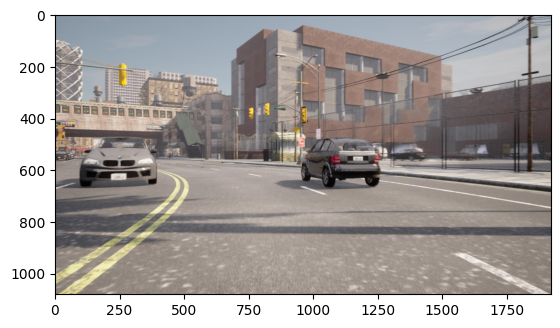

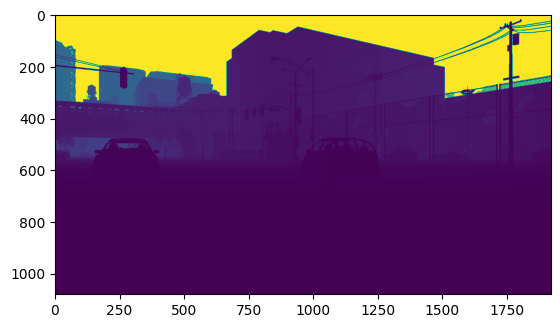

In [11]:
# Shows rgb and depth image being worked with
# DISCLAIMER: the dataset currently has a slight temporal offset between the rgb and depth images, leading to artifacts

imgName = '1080p'
startingNumber = 60
numberImages = 2
horiz_fov = 72

window = Window(imgName, startingNumber, numberImages, horiz_fov)
plt.figure()
plt.imshow(window.get_frame(0).rgbImg)
plt.figure()
plt.imshow(window.get_frame(0).depthImg)

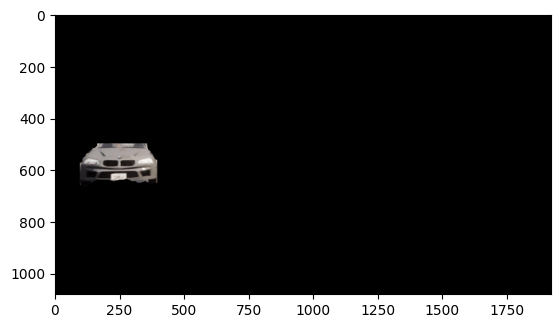

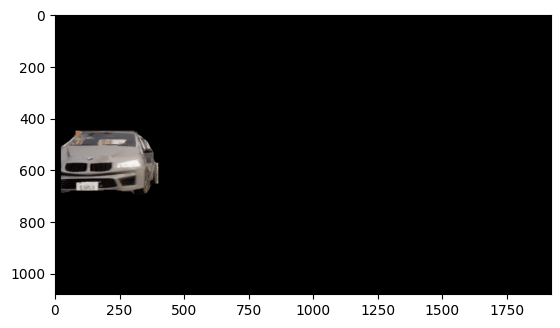

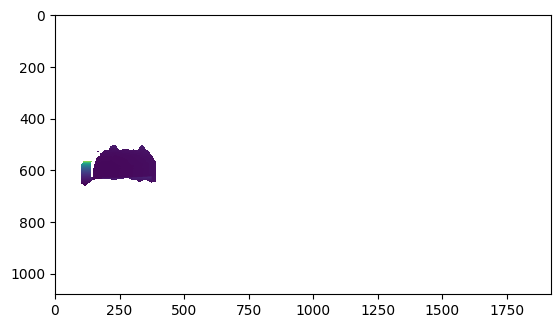

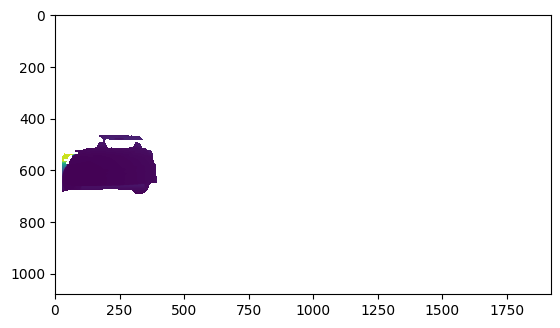

In [12]:
# Shows object being tracked through time

idx = 10
window.print_masked_img(0,idx, 'rgb', 'seg')
window.print_masked_img(1,idx, 'rgb', 'seg')
window.print_masked_img(0,idx)
window.print_masked_img(1,idx)

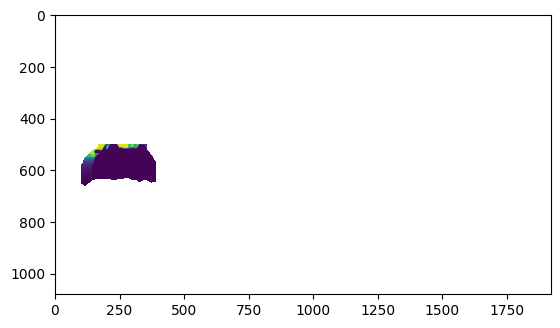

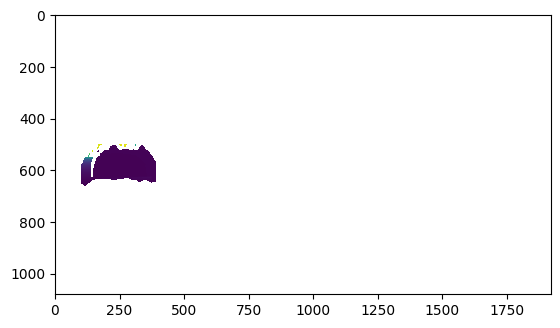

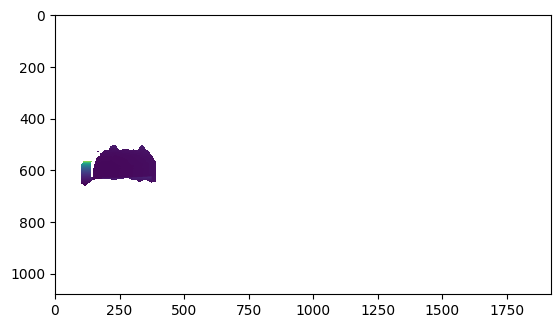

In [13]:
# Shows cleaning up of object boundary

idx = 10
window.print_masked_img(0,idx, rgb_or_d='d', mask_name='seg')
window.print_masked_img(0,idx, rgb_or_d='d', mask_name='edge')
window.print_masked_img(0,idx, rgb_or_d='d', mask_name='cart')